### For better performance you need to add deep supervision according to the paper
### Hyperparameters need to be optimized to get the best results. Use tensorflow version 2.8.4 and python version 3.7

In [1]:

from keras.utils.generic_utils import get_custom_objects
from numpy import zeros
from numpy import ones
from numpy.random import randint
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
import numpy
from PIL import Image, ImageOps
import os
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input, GlobalAveragePooling2D, Multiply,AveragePooling2D

from keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam
from keras.layers import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
import random

# DWT Pooling and Conv Block

In [2]:
!pip install tensorflow_wavelets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 55.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 66.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 74.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
ERROR: pip's dependency resolver does not currently take into account

In [3]:
import pywt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow_wavelets.utils.helpers import *
from tensorflow.keras.applications import VGG16,DenseNet201
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # for tensor flow warning
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


class DWT(layers.Layer):
    """
    Discrete Wavelet transform - tensorflow - keras
    inputs:
        name - wavelet name ( from pywavelet library)
        concat - 1 - merge transform output to one channel
               - 0 - split to 4 channels ( 1 img in -> 4 smaller img out)
    """

    def __init__(self, wavelet_name='haar', concat=1, **kwargs):
        super(DWT, self).__init__(**kwargs)
        # self._name = self.name + "_" + name
        # get filter coeffs from 3rd party lib
        wavelet = pywt.Wavelet(wavelet_name)
        self.dec_len = wavelet.dec_len
        self.concat = concat
        # decomposition filter low pass and hight pass coeffs
        db2_lpf = wavelet.dec_lo
        db2_hpf = wavelet.dec_hi

        # covert filters into tensors and reshape for convolution math
        db2_lpf = tf.constant(db2_lpf[::-1])
        self.db2_lpf = tf.reshape(db2_lpf, (1, wavelet.dec_len, 1, 1))

        db2_hpf = tf.constant(db2_hpf[::-1])
        self.db2_hpf = tf.reshape(db2_hpf, (1, wavelet.dec_len, 1, 1))

        self.conv_type = "VALID"
        self.border_padd = "SYMMETRIC"
        self.wavelet_name = wavelet_name
        self.concat = concat

    def build(self, input_shape):
        # filter dims should be bigger if input is not gray scale
        if input_shape[-1] != 1:
            # self.db2_lpf = tf.repeat(self.db2_lpf, input_shape[-1], axis=-1)
            self.db2_lpf = tf.keras.backend.repeat_elements(self.db2_lpf, input_shape[-1], axis=-1)
            # self.db2_hpf = tf.repeat(self.db2_hpf, input_shape[-1], axis=-1)
            self.db2_hpf = tf.keras.backend.repeat_elements(self.db2_hpf, input_shape[-1], axis=-1)

    def call(self, inputs, training=None, mask=None):

        # border padding symatric add coulums
        inputs_pad = tf.pad(inputs, [[0, 0], [0, 0], [self.dec_len-1, self.dec_len-1], [0, 0]], self.border_padd)

        # approximation conv only rows
        a = tf.nn.conv2d(
            inputs_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # details conv only rows
        d = tf.nn.conv2d(
            inputs_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ds - down sample
        a_ds = a[:, :, 1:a.shape[2]:2, :]
        d_ds = d[:, :, 1:d.shape[2]:2, :]

        # border padding symatric add rows
        a_ds_pad = tf.pad(a_ds, [[0, 0], [self.dec_len-1, self.dec_len-1], [0, 0], [0, 0]], self.border_padd)
        d_ds_pad = tf.pad(d_ds, [[0, 0], [self.dec_len-1, self.dec_len-1], [0, 0], [0, 0]], self.border_padd)

        # convolution is done on the rows so we need to
        # transpose the matrix in order to convolve the colums
        a_ds_pad = tf.transpose(a_ds_pad, perm=[0, 2, 1, 3])
        d_ds_pad = tf.transpose(d_ds_pad, perm=[0, 2, 1, 3])

        # aa approximation approximation
        aa = tf.nn.conv2d(
            a_ds_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ad approximation details
        ad = tf.nn.conv2d(
            a_ds_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ad details aproximation
        da = tf.nn.conv2d(
            d_ds_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # dd details details
        dd = tf.nn.conv2d(
            d_ds_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )

        # transpose back the matrix
        aa = tf.transpose(aa, perm=[0, 2, 1, 3])
        ad = tf.transpose(ad, perm=[0, 2, 1, 3])
        da = tf.transpose(da, perm=[0, 2, 1, 3])
        dd = tf.transpose(dd, perm=[0, 2, 1, 3])

        # down sample
        ll = aa[:, 1:aa.shape[1]:2, :, :]
        lh = ad[:, 1:ad.shape[1]:2, :, :]
        hl = da[:, 1:da.shape[1]:2, :, :]
        hh = dd[:, 1:dd.shape[1]:2, :, :]

        # concate all outputs ionto tensor
        if self.concat == 0:
            x = tf.concat([ll, lh, hl, hh], axis=-1)
        elif self.concat == 2:
            x = ll
        elif self.concat ==1:
            return ll,lh,hl,hh
        else:
            x = tf.concat([tf.concat([ll, lh], axis=1), tf.concat([hl, hh], axis=1)], axis=2)
        return x
    def get_config(self):
        config = super(DWT, self).get_config()
        config.update({'wavelet_name': self.wavelet_name, 'concat': self.concat})
        return config



def wavelet_conv_block(x, in_channels):
    
    ll, lh, hl, hh = DWT(concat=1)(x)
    
    y = tf.concat([ll, lh, hl, hh], axis=3)
    
    conv1 = tf.keras.layers.Conv2D(in_channels * 2, kernel_size=1, dilation_rate=1, padding='valid')(y)
    
    conv2 = tf.keras.layers.Conv2D(in_channels, kernel_size=3, dilation_rate=1, padding='same')(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2,training=True)
    conv2 = tf.keras.layers.ReLU()(conv2)

    
    conv3 = tf.keras.layers.Conv2D(in_channels, kernel_size=5, dilation_rate=1, padding='same')(conv1)
    conv3 = tf.keras.layers.BatchNormalization()(conv3,training=True)
    conv3 = tf.keras.layers.ReLU()(conv3)
    
    conv4 = tf.keras.layers.Conv2D(in_channels * 2, kernel_size=1, dilation_rate=1, padding='valid')(tf.concat([conv2, conv3], axis=3))
    
    return conv4, ll, lh, hl, hh   

# Dual-mode Attention Gate

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv,training=True)
    conv = layers.ReLU()(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv,training=True)
    conv = layers.ReLU()(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):


    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv,training=True)
    conv = layers.ReLU()(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv,training=True)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut,training=True)

    res_path = layers.add([shortcut, conv])
    res_path = layers.ReLU()(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):

    init = RandomNormal(stddev=0.02)
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization(axis=3)(x,training=True)
    x = layers.ReLU()(x)
    return x

def attention_block(x, gating, inter_shape):
    filters = x.shape[-1]
    filtersg = gating.shape[-1]
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    init = RandomNormal(stddev=0.02)
    xa = x[:, :, :, :filters // 2]
    xb = x[:, :, :, filters // 2: ]
    gating_a = gating[:, :, :, :filtersg // 2]
    gating_b = gating[:, :, :, filtersg // 2:]
# Getting the x signal to the same shape as the gating signal
    theta_xa = layers.Conv2D(inter_shape//2, (2, 2), strides=(2, 2), padding='same')(xa)  # 16
    shape_theta_xa = K.int_shape(theta_xa)
    theta_xb = layers.Conv2D(inter_shape//2, (2, 2), strides=(2, 2), padding='same')(xb)  # 16
    shape_theta_xb = K.int_shape(theta_xb)
# Getting the gating signal to the same number of filters as the inter_shape
    phi_ga = layers.Conv2D(inter_shape//2, (1, 1), padding='same')(gating_a)
    upsample_ga = layers.Conv2DTranspose(inter_shape//2, (3, 3),strides=(shape_theta_xa[1] // shape_g[1], shape_theta_xa[2] // shape_g[2]),padding='same')(phi_ga)  # 16
    phi_gb = layers.Conv2D(inter_shape//2, (1, 1), padding='same')(gating_b)
    upsample_gb = layers.Conv2DTranspose(inter_shape//2, (3, 3),strides=(shape_theta_xb[1] // shape_g[1], shape_theta_xb[2] // shape_g[2]),padding='same')(phi_gb)  # 16
    
    
    ###################################################
    concat_xg = layers.add([theta_xa,upsample_ga ])
    act_xg = layers.ReLU()(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, xa.shape[3])
    ya = layers.multiply([upsample_psi, xa])

    
    ##################################################
    subtract_xg = layers.subtract([theta_xb,upsample_gb])
    sub_act_xg = layers.ReLU()(subtract_xg)
    sub_psi = layers.Conv2D(1, (1, 1), padding='same')(sub_act_xg)
    sub_sigmoid_xg = layers.Activation('sigmoid')(sub_psi)
    sub_sigmoid_xg = -1 * (sub_sigmoid_xg) + 1
    sub_upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sub_sigmoid_xg)  # 32
    sub_upsample_psi = repeat_elem(sub_upsample_psi, xb.shape[3])
    yb = layers.multiply([sub_upsample_psi, xb])
    ##################################################
    y = layers.Concatenate(axis=3)([ya, yb])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization(axis=3)(result,training=True)
    result_bn = layers.ReLU()(result_bn)
    return result_bn

# Foreground GAN

In [4]:
def define_discriminator(image_shape):
    
    # weight initialization
    init = RandomNormal(stddev=0.02) 
    
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=(256,256,1))
    
    # concatenate images, channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    
    # C64: 4x4 kernel Stride 2x2
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128: 4x4 kernel Stride 2x2
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = BatchNormalization()(d)
    
    # C256: 4x4 kernel Stride 2x2
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = BatchNormalization()(d)
    
    # C512: 4x4 kernel Stride 2x2 
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = BatchNormalization()(d)
    
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
 
    opt = Adam(lr=0.000009, beta_1=0.5)
    model.compile(loss='mae', optimizer=opt, loss_weights=[25])
    return model

In [5]:

def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1),activation='relu', name=None):

    init = RandomNormal(stddev=0.02)
    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding,kernel_initializer=init )(x)
    x = BatchNormalization(axis=3)(x, training=True)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x

def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None,dropout=True):

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3)(x,training=True)
    if dropout:
        x = Dropout(0.5)(x, training=True)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out,training=True)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out,training=True)

    return out

def ResPath(filters, length, inp):

    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out,training=True)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,activation=None, padding='same')
        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')
        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out,training=True)

    return out





def BasicConv2D(inputs,out_planes, kernel_size, stride=1, padding='same', dilation=1):
    conv = tf.keras.layers.Conv2D(
            filters=out_planes,
            kernel_size=kernel_size,
            strides=stride,
            padding=padding,
            dilation_rate=dilation,
            use_bias=False
        )(inputs)
    bn = tf.keras.layers.BatchNormalization()(conv,training=True)
    relu = tf.keras.layers.ReLU()(bn)
    return relu
    

def RFBModified(inputs, out_channel):
    relu = tf.keras.layers.ReLU()(inputs)

    # Define branch0
    branch0 = BasicConv2D(relu, out_channel, kernel_size=1)

    # Define branch1
    conv1_1x1 = BasicConv2D(relu, out_channel, kernel_size=1)
    conv1_1x3 = BasicConv2D(conv1_1x1, out_channel, kernel_size=(1, 3), padding='same')
    conv1_3x1 = BasicConv2D(conv1_1x3, out_channel, kernel_size=(3, 1), padding='same')
    conv1_3x3 = BasicConv2D(conv1_3x1, out_channel, kernel_size=3, padding='same', dilation=3)

    # Define branch2
    conv2_1x1 = BasicConv2D(relu, out_channel, kernel_size=1)
    conv2_1x5 = BasicConv2D(conv2_1x1, out_channel, kernel_size=(1, 5), padding='same')
    conv2_5x1 = BasicConv2D(conv2_1x5, out_channel, kernel_size=(5, 1), padding='same')
    conv2_3x3 = BasicConv2D(conv2_5x1, out_channel, kernel_size=3, padding='same', dilation=5)

    # Define branch3
    conv3_1x1 = BasicConv2D(relu, out_channel, kernel_size=1)
    conv3_1x7 = BasicConv2D(conv3_1x1, out_channel, kernel_size=(1, 7), padding='same')
    conv3_7x1 = BasicConv2D(conv3_1x7, out_channel, kernel_size=(7, 1), padding='same')
    conv3_3x3 = BasicConv2D(conv3_7x1, out_channel, kernel_size=3, padding='same', dilation=7)

    # Concatenate branches
    branches_concat = tf.keras.layers.Concatenate(axis=-1)([branch0, conv1_3x3, conv2_3x3, conv3_3x3])

    # Final convolution and residual connection
    conv_cat = BasicConv2D(branches_concat, out_channel, kernel_size=3, padding='same')
    conv_res = BasicConv2D(relu, out_channel, kernel_size=1)

    # Output
    output = tf.keras.layers.ReLU()(conv_cat + conv_res)

    return output
def aggregation(x1, x2, x3):
#     relu = tf.keras.layers.ReLU()(x1)
    channel=32
    upsample = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')
    x1_1 = x1
    x1_1_1 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x1_1)
    x1_1_2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x1_1_1)
    x2_1_1 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x2)
    x2_1 = tf.math.multiply(BasicConv2D(x1_1_1 ,channel, 3, padding='same'), x2)
    x3_1 = BasicConv2D(x1_1_2,channel, 3, padding='same') 
    x3_1 = tf.math.multiply(x3_1 , BasicConv2D(x2_1_1,channel, 3, padding='same'))
    x3_1 = tf.math.multiply(x3_1, x3)

    x2_2 = tf.concat([x2_1, BasicConv2D(upsample(x1_1),2*channel, 3, padding='same')], axis=-1)
    x2_2 = BasicConv2D(x2_2,2 * channel, 3, padding='same')

    x3_2 = tf.concat([x3_1, BasicConv2D(upsample(x2_2),2 * channel, 3, padding='same')], axis=-1)
    x3_2 = BasicConv2D(x3_2,3 * channel, 3, padding='same')

    x = BasicConv2D(x3_2,3 * channel, 3, padding='same')
    x = tf.keras.layers.Conv2D(1, 1)(x)
    
    return x

    
def define_generator(height, width, n_channels):
    inputs = Input((height, width, n_channels))
    encoder = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    encoder1 = DenseNet201(include_top=False, weights="imagenet", input_tensor=inputs)
    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    
    ######################################
    wav_pool256 = DWT(name="haar",concat=0)(inputs)
    s2 = encoder.get_layer("block2_conv2").output 
    e2 = encoder1.get_layer("conv1/relu").output
    mresblock2 = Concatenate()([pool1,s2,e2])
    mresblock2 = MultiResBlock(64, mresblock2)
    mresblock2 = Concatenate()([wav_pool256, mresblock2])
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(64, 3, mresblock2)

    ###########################################
    mres_wav_pool256= DWT(concat=2)(mresblock1)
    wav_cnn128 = Concatenate()([wav_pool256, mresblock2,mres_wav_pool256])
    wav_cnn128,_,_,_,_ = wavelet_conv_block(wav_cnn128, 16)
    
    wav_out1_ll = DWT(concat=2)(inputs)
    wav_pool128 = DWT(concat=0)(wav_out1_ll)
    
    s3 = encoder.get_layer("block3_conv2").output
    e3 = encoder1.get_layer("pool2_conv").output
    mresblock3 = Concatenate()([pool2,s3,e3])
    mresblock3 = MultiResBlock(128, mresblock3)
    mresblock3 = Concatenate()([wav_cnn128, mresblock3])
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(128, 2, mresblock3)

    #############################################
    
    
    mres_wav_pool128 = DWT(concat=2)(mresblock2)
    wav_cnn64 = Concatenate()([wav_pool128, mresblock3,mres_wav_pool128])
    wav_cnn64,_,_,_,_ = wavelet_conv_block(wav_cnn64, 32)    
    
    wav_out2_ll = DWT(concat=2)(wav_out1_ll)
    wav_pool64 = DWT(concat=0)(wav_out2_ll)
    
    s4 = encoder.get_layer("block4_conv2").output
    e4 = encoder1.get_layer("pool3_conv").output
    mresblock4= Concatenate()([pool3,s4,e4])
    mresblock4 = MultiResBlock(256, mresblock4)
    mresblock4= Concatenate()([wav_cnn64, mresblock4])
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(256, 1, mresblock4)
    
    
    ###############################################
    
    mres_wav_pool64 = DWT(concat=2)(mresblock3)
    wav_cnn32 = Concatenate()([wav_pool64, mresblock4,mres_wav_pool64])
    wav_cnn32,_,_,_,_ = wavelet_conv_block(wav_cnn32, 64)
    

    
    
    s5 = encoder.get_layer("block5_conv2").output
    e5 = encoder1.get_layer("pool4_conv").output
    mresblock5= Concatenate()([pool4,s5,e5])
    mresblock5 = MultiResBlock(512, mresblock5)
    mresblock5= Concatenate()([wav_cnn32, mresblock5])
    pool5 = MaxPooling2D(pool_size=(2, 2))(mresblock5)
    mresblock5 = ResPath(512, 1, mresblock5)
    ##############################

    mresblock6 = MultiResBlock(1024, pool5)

    ###########################################
    
    gating_8 = gating_signal(mresblock6, 512, batch_norm=True)
    att_8 = attention_block(mresblock5, gating_8, 512)
    up5 = concatenate([trans_conv2d_bn(mresblock6, filters=512, num_row=2, num_col=2, padding='same', strides=(2, 2), dropout=True), att_8], axis=3)
    mresblock7 = MultiResBlock(512, up5) 
    
    
    
    
    gating_16 = gating_signal(mresblock7, 256, batch_norm=True)
    att_16 = attention_block(mresblock4, gating_16, 256)
    up6 = concatenate([trans_conv2d_bn(mresblock7, filters=256, num_row=2, num_col=2, padding='same', strides=(2, 2), dropout=True), att_16], axis=3)
    mresblock8 = MultiResBlock(256, up6)
    
    

    gating_32 = gating_signal(mresblock8, 128, batch_norm=True)
    att_32 = attention_block(mresblock3, gating_32, 128)
    up7 = concatenate([trans_conv2d_bn(mresblock8, filters=128, num_row=2, num_col=2, padding='same', strides=(2, 2), dropout=True), att_32], axis=3)
    mresblock9 = MultiResBlock(128, up7)


    
    
    
    gating_64 = gating_signal(mresblock9, 64, batch_norm=True)
    att_64 = attention_block(mresblock2, gating_64, 64)
    up8 = concatenate([trans_conv2d_bn(mresblock9, filters=64, num_row=2, num_col=2, padding='same', strides=(2, 2), dropout=False), att_64], axis=3)
    mresblock10 = MultiResBlock(64, up8)

    
    

    
    
    gating_128 = gating_signal(mresblock10, 32, batch_norm=True)
    att_128 = attention_block(mresblock1, gating_128, 32)
    up9 = concatenate([trans_conv2d_bn(mresblock10, filters=32, num_row=2, num_col=2, padding='same', strides=(2, 2), dropout=False), att_128], axis=3)
    mresblock11 = MultiResBlock(32, up9)
    
    
    init = RandomNormal(stddev=0.02)
    conv10 = conv2d_bn(mresblock11, 1, 1, 1, activation='sigmoid')
    
    
    x3_rfb=RFBModified(mresblock3,32)
    x4_rfb=RFBModified(mresblock4,32)
    x5_rfb=RFBModified(mresblock5,32)
    ra5_feat = aggregation(x5_rfb,x4_rfb,x3_rfb)

    
    crop_5 = tf.image.resize(ra5_feat, [16,16])
    x = -1 * (tf.math.sigmoid(crop_5)) + 1
    x = tf.keras.layers.Multiply()([x, mresblock5])
    
    x = BasicConv2D(x, 256, 1)
    x = BasicConv2D(x, 256, 5, padding='same')
    x = BasicConv2D(x, 256, 5, padding='same')
    x = BasicConv2D(x, 256, 5, padding='same')
    ra4_feat = BasicConv2D(x, 1, 1)
    x = tf.keras.layers.Add()([ra4_feat, crop_5])
    crop_4 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = -1 * (tf.math.sigmoid(crop_4)) + 1
    x = tf.keras.layers.Multiply()([x, mresblock4])
    x = BasicConv2D(x, 64, 1)
    x = BasicConv2D(x, 64, 3, padding='same')
    x = BasicConv2D(x, 64, 3, padding='same')
    ra3_feat = BasicConv2D(x, 1, 3, padding='same')
    x = tf.keras.layers.Add()([ra3_feat, crop_4])

    crop_3 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = -1 * (tf.math.sigmoid(crop_3)) + 1
    x = tf.keras.layers.Multiply()([x, mresblock3])
    x = BasicConv2D(x, 64, 1)
    x = BasicConv2D(x, 64, 3, padding='same')
    x = BasicConv2D(x, 64, 3, padding='same')
    ra2_feat = BasicConv2D(x, 1, 3, padding='same')
    x = tf.keras.layers.Add()([ra2_feat, crop_3])
    lateral_map_2 = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    lateral_map_2 = tf.keras.activations.sigmoid(lateral_map_2)
    

    out_image=conv10*lateral_map_2

    
    model = Model(inputs, [out_image])
    

    return model




In [6]:
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable.
            
    # define the source image
    in_src = Input(shape=image_shape)
    # suppy the image as input to the generator 
    gen_out = g_model(in_src)
    # supply the input image and generated image as inputs to the discriminator
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and disc. output as outputs
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0001, beta_1=0.5)
    
    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
    model.compile(loss=['binary_crossentropy','binary_crossentropy'],optimizer=opt, loss_weights=[1,25])
    return model


# Background GAN

In [7]:
def define_discriminator_back(image_shape):
    
    # weight initialization
    init = RandomNormal(stddev=0.02) 
    
    # source image input
    in_src_image = Input(shape=image_shape) 
    # target image input
    in_target_image = Input(shape=(256,256,1))
    
    # concatenate images, channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    
    # C64: 4x4 kernel Stride 2x2
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128: 4x4 kernel Stride 2x2
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = BatchNormalization()(d)
    
    # C256: 4x4 kernel Stride 2x2
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = BatchNormalization()(d)
    
    # C512: 4x4 kernel Stride 2x2 
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = BatchNormalization()(d)
    

    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    
    opt = Adam(lr=0.000009, beta_1=0.5)
    model.compile(loss='mae', optimizer=opt, loss_weights=[25])
    return model


def define_generator_back(height, width, n_channels):
    inputs = Input((height, width, n_channels))
    encoder = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    encoder1 = DenseNet201(include_top=False, weights="imagenet", input_tensor=inputs)
    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    
    ######################################
    wav_pool256 = DWT(name="haar",concat=0)(inputs)
    s2 = encoder.get_layer("block2_conv2").output 
    e2 = encoder1.get_layer("conv1/relu").output
    mresblock2 = Concatenate()([pool1,s2,e2])
    mresblock2 = MultiResBlock(64, mresblock2)
    mresblock2 = Concatenate()([wav_pool256, mresblock2])
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(64, 3, mresblock2)

    ###########################################
    mres_wav_pool256 = DWT(concat=2)(mresblock1)
    wav_cnn128 = Concatenate()([wav_pool256, mresblock2,mres_wav_pool256])
    wav_cnn128,_,_,_,_ = wavelet_conv_block(wav_cnn128, 16)
    
    wav_out1_ll = DWT(concat=2)(inputs)
    wav_pool128 = DWT(concat=0)(wav_out1_ll)
    
    s3 = encoder.get_layer("block3_conv2").output
    e3 = encoder1.get_layer("pool2_conv").output
    mresblock3 = Concatenate()([pool2,s3,e3])
    mresblock3 = MultiResBlock(128, mresblock3)
    mresblock3 = Concatenate()([wav_cnn128, mresblock3])
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(128, 2, mresblock3)

    #############################################
    
    
    mres_wav_pool128= DWT(concat=2)(mresblock2)
    wav_cnn64 = Concatenate()([wav_pool128, mresblock3,mres_wav_pool128])
    wav_cnn64,_,_,_,_ = wavelet_conv_block(wav_cnn64, 32)    
    
    wav_out2_ll = DWT(concat=2)(wav_out1_ll)
    wav_pool64 = DWT(concat=0)(wav_out2_ll)
    
    s4 = encoder.get_layer("block4_conv2").output
    e4 = encoder1.get_layer("pool3_conv").output
    mresblock4= Concatenate()([pool3,s4,e4])
    mresblock4 = MultiResBlock(256, mresblock4)
    mresblock4= Concatenate()([wav_cnn64, mresblock4])
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(256, 1, mresblock4)
    
    
    ###############################################
    
    mres_wav_pool64= DWT(concat=2)(mresblock3)
    wav_cnn32 = Concatenate()([wav_pool64, mresblock4,mres_wav_pool64])
    wav_cnn32,_,_,_,_ = wavelet_conv_block(wav_cnn32, 64)
    
    
    s5 = encoder.get_layer("block5_conv2").output
    e5 = encoder1.get_layer("pool4_conv").output
    mresblock5= Concatenate()([pool4,s5,e5])
    mresblock5 = MultiResBlock(512, mresblock5)
    mresblock5= Concatenate()([wav_cnn32, mresblock5])
    pool5 = MaxPooling2D(pool_size=(2, 2))(mresblock5)
    mresblock5 = ResPath(512, 1, mresblock5)
    ##############################

    mresblock6 = MultiResBlock(1024, pool5)

    ###########################################
    
    gating_8 = gating_signal(mresblock6, 512, batch_norm=True)
    att_8 = attention_block(mresblock5, gating_8, 512)
    up5 = concatenate([trans_conv2d_bn(mresblock6, filters=512, num_row=2, num_col=2, padding='same', strides=(2, 2), dropout=True), att_8], axis=3)
    mresblock7 = MultiResBlock(512, up5) 
    
    
    
    
    gating_16 = gating_signal(mresblock7, 256, batch_norm=True)
    att_16 = attention_block(mresblock4, gating_16, 256)
    up6 = concatenate([trans_conv2d_bn(mresblock7, filters=256, num_row=2, num_col=2, padding='same', strides=(2, 2), dropout=True), att_16], axis=3)
    mresblock8 = MultiResBlock(256, up6)
    
    

    gating_32 = gating_signal(mresblock8, 128, batch_norm=True)
    att_32 = attention_block(mresblock3, gating_32, 128)
    up7 = concatenate([trans_conv2d_bn(mresblock8, filters=128, num_row=2, num_col=2, padding='same', strides=(2, 2), dropout=True), att_32], axis=3)
    mresblock9 = MultiResBlock(128, up7)


    
    
    
    gating_64 = gating_signal(mresblock9, 64, batch_norm=True)
    att_64 = attention_block(mresblock2, gating_64, 64)
    up8 = concatenate([trans_conv2d_bn(mresblock9, filters=64, num_row=2, num_col=2, padding='same', strides=(2, 2), dropout=False), att_64], axis=3)
    mresblock10 = MultiResBlock(64, up8)

    
    
    gating_128 = gating_signal(mresblock10, 32, batch_norm=True)
    att_128 = attention_block(mresblock1, gating_128, 32)
    up9 = concatenate([trans_conv2d_bn(mresblock10, filters=32, num_row=2, num_col=2, padding='same', strides=(2, 2), dropout=False), att_128], axis=3)
    mresblock11 = MultiResBlock(32, up9)
    
    
    init = RandomNormal(stddev=0.02)
    conv10 = conv2d_bn(mresblock11, 1, 1, 1, activation='sigmoid')
    
    
    x3_rfb=RFBModified(mresblock3,32)
    x4_rfb=RFBModified(mresblock4,32)
    x5_rfb=RFBModified(mresblock5,32)
    ra5_feat =aggregation(x5_rfb,x4_rfb,x3_rfb)
    
    crop_5 = tf.image.resize(ra5_feat, [16,16])
    x = -1 * (tf.math.sigmoid(crop_5)) + 1
    x = tf.keras.layers.Multiply()([x, mresblock5])
    
    x = BasicConv2D(x, 256, 1)
    x = BasicConv2D(x, 256, 5, padding='same')
    x = BasicConv2D(x, 256, 5, padding='same')
    x = BasicConv2D(x, 256, 5, padding='same')
    ra4_feat = BasicConv2D(x, 1, 1)
    x = tf.keras.layers.Add()([ra4_feat, crop_5])
    crop_4 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = -1 * (tf.math.sigmoid(crop_4)) + 1
    x = tf.keras.layers.Multiply()([x, mresblock4])
    x = BasicConv2D(x, 64, 1)
    x = BasicConv2D(x, 64, 3, padding='same')
    x = BasicConv2D(x, 64, 3, padding='same')
    ra3_feat = BasicConv2D(x, 1, 3, padding='same')
    x = tf.keras.layers.Add()([ra3_feat, crop_4])

    crop_3 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = -1 * (tf.math.sigmoid(crop_3)) + 1
    x = tf.keras.layers.Multiply()([x, mresblock3])
    x = BasicConv2D(x, 64, 1)
    x = BasicConv2D(x, 64, 3, padding='same')
    x = BasicConv2D(x, 64, 3, padding='same')
    ra2_feat = BasicConv2D(x, 1, 3, padding='same')
    x = tf.keras.layers.Add()([ra2_feat, crop_3])
    lateral_map_2 = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    lateral_map_2 = tf.keras.activations.sigmoid(lateral_map_2)
    

    out_image=conv10*lateral_map_2

    
    model = Model(inputs, [out_image])
    

    return model

def define_gan_back(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False      
    # define the source image
    in_src = Input(shape=image_shape)
    # suppy the image as input to the generator 
    gen_out = g_model(in_src)
    # supply the input image and generated image as inputs to the discriminator
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and disc. output as outputs
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0001, beta_1=0.5)
    
    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
    model.compile(loss=['binary_crossentropy','binary_crossentropy'],optimizer=opt, loss_weights=[1,25])
    return model


# Augmentation and data loader

In [8]:
import albumentations as A
aug1 = A.HorizontalFlip(p=1)
aug2 = A.VerticalFlip(p=1)
aug3 = A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1)
aug4 = A.GaussianBlur (blur_limit=(15, 15), sigma_limit=2.5, always_apply=True, p=1)
aug5 = A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, always_apply=True, p=1)
aug6 = A.Rotate(limit=90, interpolation=1, border_mode=2, value=None, mask_value=None, rotate_method='largest_box', crop_border=False, always_apply=True, p=1)
aug7 = A.Downscale(scale_min=0.125, scale_max=0.25, interpolation=None, always_apply=True, p=1)
aug8 = A.RandomBrightnessContrast (brightness_limit=0.4, contrast_limit=0.3, brightness_by_max=True, always_apply=True, p=1)
def augment(image,mask,n):
    if n==0:
        augmented = aug6(image=image, mask=mask)
    elif n==1:
        augmented = aug1(image=image, mask=mask)
    elif n==2: 
        augmented = aug2(image=image, mask=mask)
    elif n==3: 
        augmented = aug3(image=image, mask=mask)
    elif n==4: 
        augmented = aug4(image=image, mask=mask)
    elif n==5: 
        augmented = aug5(image=image, mask=mask)
    elif n==6:
        augmented = aug6(image=image, mask=mask)
    elif n==7:
        augmented = aug7(image=image, mask=mask)
    elif n==8:
        augmented = aug8(image=image, mask=mask)
    else: 
        return image,mask
    
    
        
    image_aug= augmented['image']
    mask_aug = augmented['mask']
    return image_aug,mask_aug

def generate_real_samples(data_generator,mask_generator, n_samples,patch_shape, i):
    ix = randint(0, len(data_generator), n_samples)
    n = i % 10

    # Initialize lists to store augmented images and masks
    X1 = []
    X2 = []
    X3 = []

    for i in ix:
        augmented_image, augmented_mask = augment(
            np.reshape(data_generator[i], [256,256, 3]),  # Input image
            np.reshape(mask_generator[i], [256,256, 1]),  # Input mask
            n  # Augmentation type
        )
        X1.append(augmented_image)
        X2.append(augmented_mask)
        X3.append(1-augmented_mask)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [np.array(X1), np.array(X2), np.array(X3)],y


def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((2, patch_shape, patch_shape, 1))
    return X, y


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/dropout/cutout.py:51: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1555: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  "Using default interpolation INTER_NEAREST, which is sub-optimal."


In [9]:
!pip install natsort

In [10]:
import os
import natsort
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train1p = '/kaggle/input/brain256/brain_dataset/train/img'
train2p = '/kaggle/input/brain256/brain_dataset/train/label'
val1p = '/kaggle/input/brain256/brain_dataset/val/img'
val2p = '/kaggle/input/brain256/brain_dataset/val/label'
test1p = '/kaggle/input/brain256/brain_dataset/test/img'
test2p = '/kaggle/input/brain256/brain_dataset/test/label'
train1 = '/kaggle/input/brain256/brain_dataset/train/img/'
train2 = '/kaggle/input/brain256/brain_dataset/train/label/'
val1 = '/kaggle/input/brain256/brain_dataset/val/img/'
val2 = '/kaggle/input/brain256/brain_dataset/val/label/'
test1 = '/kaggle/input/brain256/brain_dataset/test/img/'
test2 = '/kaggle/input/brain256/brain_dataset/test/label/'

import glob
import pandas as pd

train1 = glob.glob(train1+ '/*.png')  # Adjust the file extension if needed
train2 = glob.glob(train2 + '/*.png')
val1 = glob.glob(val1 + '/*.png')
val2 =glob.glob(val2 + '/*.png')
test1=glob.glob(test1 + '/*.png')
test2=glob.glob(test2 + '/*.png')


# Create ImageDataGenerator for images
from sklearn.model_selection import train_test_split

train1 = natsort.natsorted(train1)
train2 = natsort.natsorted(train2)
val1 = natsort.natsorted(val1)
val2 = natsort.natsorted(val2)
test1 = natsort.natsorted(test1)
test2 = natsort.natsorted(test2)
# Split the data into train and test sets
df_image_train = pd.DataFrame(train1, columns=['path'])
df_mask_train = pd.DataFrame(train2, columns=['path'])
df_image_val = pd.DataFrame(val1, columns=['path'])
df_mask_val = pd.DataFrame(val2, columns=['path'])
df_image_test = pd.DataFrame(test1, columns=['path'])
df_mask_test = pd.DataFrame(test2, columns=['path'])

# Create ImageDataGenerator for images
imggen = ImageDataGenerator(rescale=1./255)

train_data_generator = imggen.flow_from_dataframe(
    dataframe=df_image_train,
    x_col='path',
    y_col=None,
    directory=train1p,
    target_size=(256,256),
    color_mode='rgb',
    class_mode=None,
    shuffle=False,
    batch_size=1,
    interpolation='nearest'
)


test_data_generator = imggen.flow_from_dataframe(
    dataframe=df_image_test,
    x_col='path',
    y_col=None,
    directory=test1p,
    target_size=(256,256),
    color_mode='rgb',
    class_mode=None,
    shuffle=False,
    batch_size=1,
    interpolation='nearest'
)

valid_data_generator = imggen.flow_from_dataframe(
    dataframe=df_image_val,
    x_col='path',
    y_col=None,
    directory=val1p,
    target_size=(256,256),
    color_mode='rgb',
    class_mode=None,
    shuffle=False,
    batch_size=1,
    interpolation='nearest'
)

# Create ImageDataGenerator for masks
mask_data_generator = imggen.flow_from_dataframe(
    dataframe=df_mask_train,
    x_col='path',
    y_col=None,
    directory=train2p,
    target_size=(256,256),
    color_mode='grayscale',
    class_mode=None,
    shuffle=False,
    batch_size=1,
    interpolation='nearest'
)


mask_data_generator_test = imggen.flow_from_dataframe(
    dataframe=df_mask_test,
    x_col='path',
    y_col=None,
    directory=test2p,
    target_size=(256,256),
    color_mode='grayscale',
    class_mode=None,
    shuffle=False,
    batch_size=1,
    interpolation='nearest'
)
mask_data_generator_valid = imggen.flow_from_dataframe(
    dataframe=df_mask_val,
    x_col='path',
    y_col=None,
    directory=val2p,
    target_size=(256,256),
    color_mode='grayscale',
    class_mode=None,
    shuffle=False,
    batch_size=1,
    interpolation='nearest'
)

Found 254 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 254 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.


In [11]:
def summarize_performance(step, g_model1,g_model2):

    filename2 = 'lesion_model_%06d.h5' % (step+1)
    g_model1.save(filename2)
    filename4 = 'background_model_%06d.h5' % (step+1)
    g_model2.save(filename4)
    print('>Saved: %s and %s' % (filename2,filename4))

def remove_prev_performance(score_epoch):
    filename3 = 'lesion_model_%06d.h5' % (score_epoch)
    filename5 = 'background_model_%06d.h5' % (score_epoch)
    os.remove("/kaggle/working/"+filename3)
    os.remove("/kaggle/working/"+filename5)
    print('>Removed: %s and %s and updated' % (filename3,filename5))

def summarize_performancet(step, g_model1,g_model2,d_model1,d_model2):

    filename2 = 'lesion_model_%06d.h5' % (step+1)
    g_model1.save(filename2)
    filename4 = 'background_model_%06d.h5' % (step+1)
    g_model2.save(filename4)
    filename1 = 'lesion_dis_%06d.h5' % (step+1)
    d_model1.save(filename1)
    filename3 = 'background_dis_%06d.h5' % (step+1)
    d_model2.save(filename3)
    print('>Saved: %s and %s , %s and %s' % (filename2,filename4,filename1,filename3))

def remove_prev_performancet(score_epoch):
    filename3 = 'lesion_model_%06d.h5' % (score_epoch)
    filename5 = 'background_model_%06d.h5' % (score_epoch)
    filename7 = 'lesion_dis_%06d.h5' % (score_epoch)
    filename9 = 'background_dis_%06d.h5' % (score_epoch)
    os.remove("/kaggle/working/"+filename3)
    os.remove("/kaggle/working/"+filename5)
    os.remove("/kaggle/working/"+filename7)
    os.remove("/kaggle/working/"+filename9)
    print('>Removed: %s and %s, %s and %s and updated' % (filename3,filename5,filename7,filename9))    
    
import tensorflow as tf
from tensorflow.image import ssim


def log_ssim_mse_loss(y_true, y_pred, alpha=0.4):
    ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    loss = -tf.math.log(ssim) * alpha + mse * (1 - alpha)
    return loss*5

def boundary_loss(y_true, y_pred):
    # Compute the gradient of the predicted and ground truth masks
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)

    # Compute the boundary term of the loss function
    term_1 = tf.abs(tf.reduce_mean(tf.abs(dy_true) - tf.abs(dy_pred)))
    term_2 = tf.abs(tf.reduce_mean(tf.abs(dx_true) - tf.abs(dx_pred)))

    # Return the sum of the two terms as the boundary loss
    return (term_1 + term_2)*5


def mae_loss(y_true, y_pred):
    return mean_absolute_error(tf.reshape(y_true, [-1]), tf.reshape(y_pred, [-1]))

# training

In [12]:

def train(d_model, g_model, gan_model,d_model2,g_model2,gan_model2, train_data_generator,mask_data_generator, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    bat_per_epo = int(len(train_data_generator)/ n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    print('starting')
    dloss11=[]
    dloss21=[]
#     dloss31=[]
    gloss1=[]
    score1=[]
    Bdloss11=[]
    Bdloss21=[]
    rloss11=[]
#     Bdloss31=[]
    Bgloss1=[]
    Bscore1=[]
    merge_score=[]
    epochss=[]
    epochss = list(range(0,n_epochs))
    score_max=0
    score_epoch=0
    
#     dloss1.append(0)
#     dloss2.append(0)
#     gloss.append(0)
    # manually enumerate epochs
    for j in range(n_epochs):
        dloss1=[]
        dloss2=[]
#         dloss3=[]
        gloss=[]
        Bdloss1=[]
        Bdloss2=[]
#         Bdloss3=[]
        Bgloss=[]
        rloss=[]
        iou_score=[]
        iou_scoreB=[]
        iou_score_merge=[]
        maxv1=0
        count1=0
        maxv2=0
        count2=0
        for i in range(bat_per_epo):
        ##for lesion
        # select a batch of real samples
            [X_realA, X_realB, X_realC], y_real = generate_real_samples(train_data_generator,mask_data_generator, n_batch, n_patch,i)
        # generate a batch of fake samples
#             X_realA1=wav_decom128(X_realA)
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
            X_fakeC, y_fake = generate_fake_samples(g_model2, X_realA, n_patch)
        # update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
            
            Bd_loss1 = d_model2.train_on_batch([X_realA, X_realC], y_real)
        # update discriminator for generated samples
            Bd_loss2 = d_model2.train_on_batch([X_realA, X_fakeC], y_fake)
        # update the generator
        
            X_realA_s = (X_realA)
            X_fakeB1 = (X_fakeB)
            X_fakeB1 = np.around(X_fakeB1)
            BX_fakeB1 = (X_fakeC)
            BX_fakeB1 = np.around(BX_fakeB1)
            X_fakeBnew = tf.cast(np.logical_or(X_fakeB1,BX_fakeB1), tf.float32) 
            X_realA_recons = tf.cast(np.multiply(X_realA_s,X_fakeBnew),tf.float32)
            BX_fakeB2 = (1-X_fakeC)
            BX_fakeB2 = (BX_fakeB2)
            BX_fakeB2 = np.around(BX_fakeB2)
            X_fakeBnew2 = tf.cast(np.logical_and(X_fakeB1,BX_fakeB2), tf.float32) 
            reconstruction_loss = log_ssim_mse_loss(X_realA_s, X_realA_recons) + (tf.keras.backend.mean(tf.keras.losses.MAE( tf.cast(X_realB, tf.float32), X_fakeBnew2))*2) + boundary_loss(tf.cast(X_realB, tf.float32), X_fakeBnew2)
            gan_model.add_loss(lambda:reconstruction_loss)
            gan_model2.add_loss(lambda:reconstruction_loss)  
            
            
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
            Bg_loss, _, _ = gan_model2.train_on_batch(X_realA, [y_real, X_realC])

            dloss1.append(d_loss1)
            dloss2.append(d_loss2)
#             dloss3.append(d_loss3)
            gloss.append(g_loss)
            rloss.append(reconstruction_loss)

            Bdloss1.append(Bd_loss1)
            Bdloss2.append(Bd_loss2)
#             Bdloss3.append(Bd_loss3)
            Bgloss.append(Bg_loss)
            
#         summarize performance
        test_iou_score1=[]
        test_iou_score1or=[]
        l=0
        for l in range(32):
            output=tf.reshape(test_data_generator[l], [1, 256,256, 3])
            gen_lesion_image1 = g_model.predict(output)
            gen_back_image1 = g_model2.predict(output)
            gen_lesion_image1 = (gen_lesion_image1)
            gen_lesion_image1 = np.around(gen_lesion_image1)
            gen_back_image1 = (1-gen_back_image1)
            gen_back_image1 = np.around(gen_back_image1)
#             gen_back_image1 = (gen_back_image1 + 1) / 2.0
            
            tar_image1 = np.around(mask_data_generator_test[l])
            gen_image1 = numpy.logical_and(gen_lesion_image1,gen_back_image1 )
            gen_image1or = numpy.logical_or(gen_lesion_image1,gen_back_image1 )
            intersection1 = numpy.logical_and(gen_image1, tar_image1)
            union1 = numpy.logical_or(gen_image1, tar_image1)
            test_iou_score1.append(numpy.sum(intersection1) / numpy.sum(union1))
            intersection1or = numpy.logical_and(gen_image1or, tar_image1)
            union1or = numpy.logical_or(gen_image1or, tar_image1)
            test_iou_score1or.append(numpy.sum(intersection1or) / numpy.sum(union1or))
        test_iou_score2=numpy.mean(test_iou_score1)
        test_iou_score2or=numpy.mean(test_iou_score1or)
        
        
        test_iou_score1v=[]
        test_iou_score1orv=[]
        l=0
        for l in range(32):
            output=tf.reshape(valid_data_generator[l], [1, 256,256, 3])
            gen_lesion_image1 = g_model.predict(output)
            gen_back_image1 = g_model2.predict(output)
            gen_lesion_image1 = (gen_lesion_image1)
            gen_lesion_image1 = np.around(gen_lesion_image1)
            gen_back_image1 = (1-gen_back_image1)
            gen_back_image1 = np.around(gen_back_image1)
#             gen_back_image1 = (gen_back_image1 + 1) / 2.0
            
            tar_image1 = np.around(mask_data_generator_valid[l])
            gen_image1 = numpy.logical_and(gen_lesion_image1,gen_back_image1 )
            gen_image1or = numpy.logical_or(gen_lesion_image1,gen_back_image1 )
            intersection1 = numpy.logical_and(gen_image1, tar_image1)
            union1 = numpy.logical_or(gen_image1, tar_image1)
            test_iou_score1v.append(numpy.sum(intersection1) / numpy.sum(union1))
            intersection1or = numpy.logical_and(gen_image1or, tar_image1)
            union1or = numpy.logical_or(gen_image1or, tar_image1)
            test_iou_score1orv.append(numpy.sum(intersection1or) / numpy.sum(union1or))
        test_iou_score2v=numpy.mean(test_iou_score1v)
        test_iou_score2orv=numpy.mean(test_iou_score1orv)
        lr_scheduler_f.on_epoch_end(j+1, {'val_iou': max(test_iou_score2v,test_iou_score2orv)})
        lr_scheduler_b.on_epoch_end(j+1, {'val_iou': max(test_iou_score2v,test_iou_score2orv)})

        dloss1m=numpy.mean(dloss1)
        dloss2m=numpy.mean(dloss2)
#         dloss3m=numpy.mean(dloss3)
        glossm=numpy.mean(gloss)
        Bdloss1m=numpy.mean(Bdloss1)
        Bdloss2m=numpy.mean(Bdloss2)
        rlossm=numpy.mean(rloss)
#         Bdloss3m=numpy.mean(Bdloss3)
        Bglossm=numpy.mean(Bgloss)
        print('Epoch %d> d1[%.3f] d2[%.3f]  g[%.3f] Bd1[%.3f] Bd2[%.3f]  Bg[%.3f]  r[%.3f] valid and:[%.3f] valid or:[%.3f]  test_iou_and:[%.5f] test_iou_OR:[%.5f]' % (j+1, dloss1m, dloss2m, glossm,Bdloss1m, Bdloss2m,  Bglossm,rlossm,test_iou_score2v,test_iou_score2orv,test_iou_score2,test_iou_score2or))

        if max(test_iou_score2,test_iou_score2or)>=score_max:
            summarize_performance((j), g_model,g_model2)
            if j!=0:
                remove_prev_performance(score_epoch)
            score_max=max(test_iou_score2,test_iou_score2or)
            score_epoch=j+1

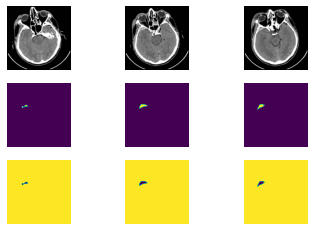

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


74850304/74836368 [==============================] - 0s 0us/step
(None, 64, 64, 32)
(None, 64, 64, 32)
(None, 16, 16, 1)
(None, 64, 64, 32)
(None, 64, 64, 32)
starting
Epoch 1> d1[10.304] d2[12.921]  g[9.194] Bd1[7.254] Bd2[14.291]  Bg[24.486]  r[1.768] valid and:[0.000] valid or:[0.005]  test_iou_and:[0.00070] test_iou_OR:[0.00817]


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


>Saved: lesion_model_000001.h5 and background_model_000001.h5


In [ ]:
from matplotlib import pyplot
import numpy as np

n_samples = 3
for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow((np.reshape(train_data_generator[i],[256,256,3])*255).astype('uint8'))
# plot target image
for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow((np.reshape(mask_data_generator[i],[256,256,1])*255).astype('uint8'))
for i in range(n_samples):
    pyplot.subplot(3, n_samples, 4 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow((np.reshape((1-mask_data_generator[i]),[256,256,1])*255).astype('uint8'))
pyplot.show()

#######################################

image_shape = (256,256,3)
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(height=256, width=256, n_channels=3)
d_model2 = define_discriminator_back(image_shape)
g_model2 = define_generator_back(height=256, width=256, n_channels=3)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
gan_model2 = define_gan_back(g_model2, d_model2, image_shape)

from tensorflow.keras.callbacks import Callback 
class LearningRateSchedulerWithPatienceIoU(Callback):
    def __init__(self, reduce_lr_factor, patience, min_lr, monitor='val_iou',model= None):
        super(LearningRateSchedulerWithPatienceIoU, self).__init__()
        self.reduce_lr_factor = reduce_lr_factor
        self.patience = patience
        self.min_lr = min_lr
        self.monitor = monitor
        self.wait = 0
        self.best_iou = -float('inf')
        self.model = model
    def on_epoch_end(self, epoch, logs=None):
        current_iou = logs.get(self.monitor, -float('inf'))

        if current_iou > self.best_iou:
            self.best_iou = current_iou
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = self.model.optimizer.lr.numpy() * self.reduce_lr_factor
                new_lr = max(new_lr, self.min_lr)
                self.model.optimizer.lr.assign(new_lr)
                print(f"\nReduced learning rate to {new_lr} after {self.patience} epochs without improvement in IoU.\n")
                self.wait = 0


initial_learning_rate = 0.0001  # Initial learning rate
reduce_lr_factor = 0.5  # Factor by which to reduce the learning rate
patience = 35  # Number of epochs without improvement in IoU before reducing learning rate
min_learning_rate = 1e-7  # Minimum learning rate

# Create the custom learning rate scheduler
lr_scheduler_f = LearningRateSchedulerWithPatienceIoU(reduce_lr_factor, patience, min_learning_rate,model=gan_model)
lr_scheduler_b = LearningRateSchedulerWithPatienceIoU(reduce_lr_factor, patience, min_learning_rate,model=gan_model2)


from datetime import datetime 
start1 = datetime.now() 

train(d_model, g_model, gan_model,d_model2,g_model2,gan_model2,train_data_generator,mask_data_generator, n_epochs=300, n_batch=2) 

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)